# Exploring Unsupervised Methods 

Documenting progress & observations below.

Methods:
- **K-means**: Identifies patterns via clustering

  - ADV: 

  - DISADV: can be skewed by outliers (via usage of mean), must chose k

- **DBSCAN**: Identifies patterns via use of a minimum radius and sequential clustering

  - ADV: avoids heavy influence by outliers, good for ds with many features

  - DISADV: heavily influenced by choice of radius + peers

- **PCA**: Reduce dimensionality of ds by identifying the most varying features

  - ADV: reducing computational power expense

  - DISADV: reduction in accuracy

  - OTHER: can be used in conjunction with other methods

Importing Libraries

In [16]:
from TelescopeML.StatVisAnalyzer import *
from TelescopeML.DataMaster import *
from TelescopeML.Predictor import *
import os 

1. Processing Data (pulled from existing notebooks)

In [17]:
# obtain data
__reference_data_path__ = os.getenv("TelescopeML_reference_data")
train_BD = pd.read_csv(os.path.join(__reference_data_path__, 'training_datasets', 'browndwarf_R100_v4_newWL_v3.csv.bz2'), compression='bz2')

output_names = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']
wavelength_names = [item for item in train_BD.columns.to_list() if item not in output_names]
wavelength_values = [float(item) for item in wavelength_names]

# initialize i/o for model
X = train_BD.drop(columns=output_names)
y = train_BD[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]

data_processor = DataProcessor( 
    flux_values=X.to_numpy(),
    wavelength_names=X.columns,
    wavelength_values=wavelength_values,
    output_values=y.to_numpy(),
    output_names=output_names,
    spectral_resolution=200,
    trained_ML_model=None,
    trained_ML_model_name='CNN',
)

data_processor.split_train_validation_test(test_size=0.1, 
    val_size=0.1, 
    random_state_=42,)

# standardize rows and columns
data_processor.standardize_X_row_wise() 
data_processor.standardize_y_column_wise()               

2. Feature Engineering (Take Min and Max of each row)

In [18]:
# train
data_processor.X_train_min = data_processor.X_train.min(axis=1)
data_processor.X_train_max = data_processor.X_train.max(axis=1)

# validation
data_processor.X_val_min = data_processor.X_val.min(axis=1)
data_processor.X_val_max = data_processor.X_val.max(axis=1)

# test
data_processor.X_test_min = data_processor.X_test.min(axis=1)
data_processor.X_test_max = data_processor.X_test.max(axis=1)

df_MinMax_train = pd.DataFrame((data_processor.X_train_min, data_processor.X_train_max)).T
df_MinMax_val = pd.DataFrame((data_processor.X_val_min, data_processor.X_val_max)).T
df_MinMax_test = pd.DataFrame((data_processor.X_test_min, data_processor.X_test_max)).T

df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)
df_MinMax_val.rename(columns={0:'min', 1:'max'}, inplace=True)
df_MinMax_test.rename(columns={0:'min', 1:'max'}, inplace=True)

data_processor.standardize_X_column_wise(
    output_indicator='Trained_StandardScaler_X_ColWise_MinMax',
    X_train = df_MinMax_train.to_numpy(),
    X_val   = df_MinMax_val.to_numpy(),
    X_test  = df_MinMax_test.to_numpy(),
    )

K-means

In [19]:
from sklearn.cluster import KMeans
import pandas as pd
from UnsupervisedDeepTrainer import * # change later perhaps

x_vals = np.array(data_processor.X_train_standardized_rowwise)
ap    = data_processor.y_train_standardized_columnwise
df = pd.DataFrame(x_vals)

In [22]:
uml = UnsupervisedML(x_vals[:5000])
history, res = uml.build_and_train_model(epochs=2)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5000, 104)]       0         
                                                                 
 conv1d_3 (Conv1D)           (None, 5000, 16)          5008      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1250, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 1250, 16)          784       
                                                                 
 up_sampling1d_1 (UpSamplin  (None, 5000, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 5000, 104)         5096

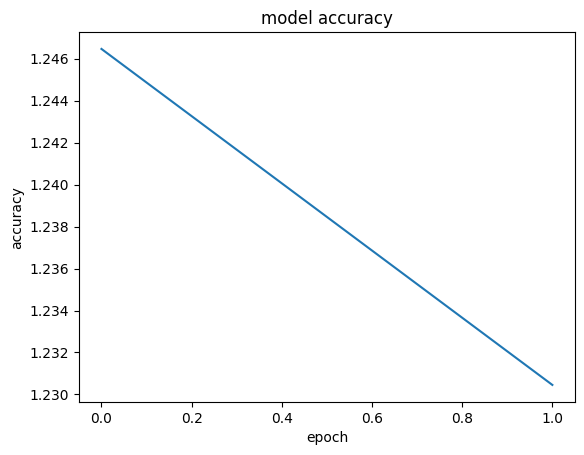

In [23]:
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


In [25]:
model = UnsupervisedML(x_vals)
labels = model.kmeans()
db_labels = model.DBscan(0.3)


c:\Users\janso\easy_access_files\telescopeML\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [26]:

def plot_clusters(
        cluster_alg, 
        labels, # column of cluster labels
        df, # df of wavelengths
        ap=[], # atmospheric parameters
        xvar="c_o_ratio",
        yvar="temperature"
    ):
    """Plots clusters with respect to different variables."""
    if len(ap != 0):
        df['gravity'] = ap[:,[0]]
        df['c_o_ratio'] = ap[:,[1]]
        df['metallicity'] = ap[:,[2]]
        df['temperature'] = ap[:,[3]]

    if cluster_alg == "kmeans":
        kmeans_df = df
        kmeans_df['kmeans'] = labels
        fig, ax = plt.subplots()
        plt.scatter(x=kmeans_df[xvar],y=kmeans_df[yvar],c=kmeans_df['kmeans'])
        plt.gca().update(dict(title=f'{xvar} vs {yvar}', xlabel=xvar, ylabel=yvar))
        plt.colorbar()
        plt.show()

        return [fig,ax]

    if cluster_alg == "dbscan":
        dbscan_df = df
        dbscan_df['dbscan'] = labels
        plt.scatter(x=dbscan_df[xvar],y=dbscan_df[yvar],c=dbscan_df['dbscan'])
        plt.gca().update(dict(title=f'{xvar} vs {yvar}', xlabel=xvar, ylabel=yvar))
        plt.colorbar()
        plt.show()
        return
    print("Enter kmeans or dbscan as an option to plot.")


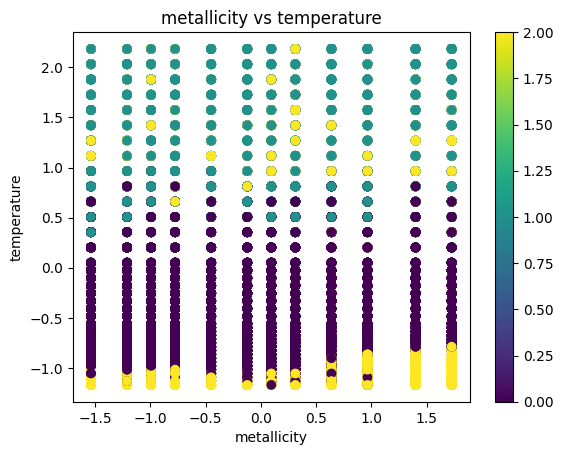

[<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'metallicity vs temperature'}, xlabel='metallicity', ylabel='temperature'>]

In [27]:
plot_clusters("kmeans", labels, df, ap, "metallicity", "temperature")

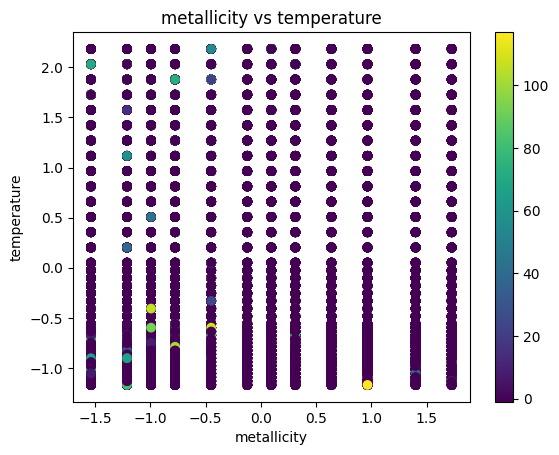

In [29]:
plot_clusters("dbscan", db_labels, df, ap, "metallicity", "temperature")

# References

Used for understanding purpose and background of TelescopeML:

- https://github.com/EhsanGharibNezhad/TelescopeML
- Gharib-Nezhad et al. (2024). TelescopeML – I. An End-to-End Python Package for Interpreting Telescope Datasets through Training
Machine Learning Models, Generating Statistical Reports, and Visualizing Results’ Journal of Open Source Software, 9(99), 6588. https:
//doi.org/10.21105/joss.06346.

Other Resources Consulted: 
- Streamlit Tutorial https://www.youtube.com/watch?v=D0D4Pa22iG0&t=41s 
- K-Means Tutorial https://www.youtube.com/watch?v=iNlZ3IU5Ffw&pp=ygUWa21lYW5zIHR1dG9yaWFsIHB5dGhvbg%3D%3D 
- DBSCAN Tutorial https://www.youtube.com/watch?v=2eDFjw456AM 
- PCA Tutorial https://www.youtube.com/watch?v=8klqIM9UvAc&pp=ygUScGNhdHV0b3JpYWwgcHl0aG9u
- CNN - K-means model mix https://arxiv.org/pdf/1906.03359 
- CNN & K-means Algorithm descriptors https://www.cs.rice.edu/~as143/COMP642_Spring22/Scribes/Lect15 
- Autoencoder Theory Explanation https://www.youtube.com/watch?v=qUf_pJ4OHH0 
- Keras Documentation https://keras.io/api/layers/pooling_layers/max_pooling2d/ 
- Tensorflow Documentation https://www.tensorflow.org/api_docs/python/tf 
- Streamlit Documentation https://docs.streamlit.io/
- Unsupervised Classification https://www.aanda.org/articles/aa/full_html/2018/04/aa32134-17/aa32134-17.html 